In [1]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [2]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const nm2au = 18.897

18.897

In [3]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [4]:
σ = 400*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [5]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

In [6]:
function discretize(sd::fitsd, num_osc::Int)
    ws = zeros(num_osc)
    for i in 1:num_osc  
        ws[i] = i*(sd.ωmax/num_osc)
    end

    J = sd.(ws)

    cs = sqrt.((2/π).*(ws.*J))
    ws, cs
end

discretize (generic function with 1 method)

Ordejon paper mentions that Hamiltonian electronic terms are $\epsilon_0$ , $\epsilon_{AA+b}$ and $\epsilon_{AA+2b}$ for nearest 2 neighbours and additionally mentions that the coupling terms for nearest 2 neighbours on either side. Further mentions the couplings $\epsilon$AB, AC, AD for neighbours on the same unit cell. However, the value for $\epsilon_0$ (site energies) isn't mentioned in the paper? Perhaps worth doing some TD-DFT ourselves? Or alternatively some TrESP-ish method for 1-D... have to think about this for a bit

In [7]:
ϵ0 = 0 # This appears to not change the dynamics at all
ϵb = 134.0
ϵ2b = -10.7

-10.7

In [8]:
N = 5

5

In [9]:
H0 = Matrix{ComplexF64}(zeros(N, N))

5×5 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [10]:
for i in 1:N
    H0[i,i] = ϵ0
    if i <= N-2
        H0[i, i+2] = ϵ2b
    end
    if i <= N-1
        H0[i, i+1] = ϵb
    end
    if i >= 2
        H0[i, i-1] = ϵb
    end
    if i>=3
        H0[i, i-2] = ϵ2b
    end
end

In [11]:
H0 = H0 * invcm2au

5×5 Matrix{ComplexF64}:
         0.0+0.0im  0.000610548+0.0im  …          0.0+0.0im
 0.000610548+0.0im          0.0+0.0im             0.0+0.0im
 -4.87527e-5+0.0im  0.000610548+0.0im     -4.87527e-5+0.0im
         0.0+0.0im  -4.87527e-5+0.0im     0.000610548+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im

In [213]:
ωp = [57.8, 59.6, 89.0, 107.3, 139.1, 639.1, 1011.2, 1344.7, 1593.3] .* invcm2au
ωpg0p = [-1.7, 1.4, 1.6, -0.14, -2.3, -7.5, -3.6, 19.8, -42.0] * mev2invcm * invcm2au
#g0p = ωpg0p ./ ωp
jws = (ωpg0p .^ 2) ./ ωp
wm = maximum(ωp)
Jw = fitsd(ωp, jws, wm, 1.0, false)

fitsd([0.000263355874, 0.00027155726800000003, 0.00040551337, 0.0004888942090000001, 0.000633785503, 0.002911950503, 0.004607360896, 0.006126896951000001, 0.007259600589], [1.4821822592674006e-5, 9.748581302564107e-6, 8.526711424100102e-6, 5.414869018013244e-8, 1.127353580377361e-5, 2.6090675037956897e-5, 3.799264651919603e-6, 8.642444157405988e-5, 0.00032819550685341046], 0.007259600589, 1.0, false)

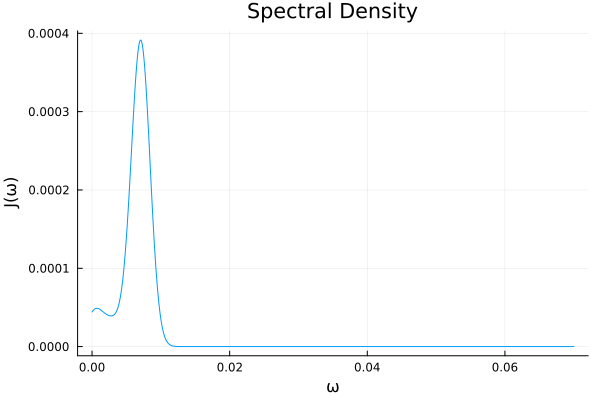

In [214]:
ω = 0:0.0001:0.07
plot(ω, Jw.(ω), xlabel="ω", ylabel="J(ω)", title="Spectral Density", legend=false)

In [215]:
nsteps = 50
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[5, 5] = 1.0

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [216]:
dt = 10/au2fs 

413.4137457575099

In [217]:
d = 0.3

0.3

In [218]:
ωs, cs = discretize(Jw, 100)

([7.259600589e-5, 0.00014519201178, 0.00021778801767000002, 0.00029038402356, 0.00036298002945, 0.00043557603534000004, 0.00050817204123, 0.00058076804712, 0.0006533640530100001, 0.0007259600589  …  0.00660623653599, 0.00667883254188, 0.006751428547770001, 0.00682402455366, 0.00689662055955, 0.006969216565440001, 0.00704181257133, 0.00711440857722, 0.00718700458311, 0.007259600589], [4.568411576327361e-5, 6.51888481319755e-5, 8.04592258579185e-5, 9.351488284617583e-5, 0.0001051152947993999, 0.00011563751540161236, 0.00012529830077687777, 0.00013423482707070172, 0.0001425404703211618, 0.00015028284834202928  …  0.0012488387713103846, 0.0012656843181004863, 0.001280947028922187, 0.0012945536173301, 0.0013064373173929883, 0.0013165383710130223, 0.0013248044751461151, 0.0013311911834765799, 0.0013356622574979453, 0.0013381899624322496])

QCPI doesn't like Gaussian-broadened Spectral Density. Stuck here...

In [173]:
## QCPI Run

#hb = Solvents.HarmonicBath(β, ωp, ωpg0p, [1.0, 2.0, 3.0, 4.0, 5.0].*d, 1000)
hb = Solvents.HarmonicBath(β, ωs, cs, [1.0, 2.0, 3.0, 4.0, 5.0].*d, 1000)
tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=[1.0 2.0 3.0 4.0 5.0].*d, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

(0.0:413.4137457575099:20670.687287875495, [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 1.6485237462719224e-18 + 0.0im -9.702353080604964e-18 - 2.5801399996845702e-17im … -1.7715830344745908e-13 + 2.0852015691187096e-14im -3.1511753646706517e-10 - 9.688069750950468e-11im; … ; 1.227260974983101e-14 + 3.852641719124798e-31im -1.1972067958328024e-14 - 7.790201636990056e-15im … -6.8781602869452304e-12 - 8.240329483159285e-12im 6.021527221488604e-10 + 1.3179345490355744e-9im; 1.2683562628818201e-14 + 3.438609173589845e-31im 8.910385273598187e-16 - 6.9789248269894734e-15im … -2.7147064906284458e-12 - 1.143226813757599e-11im 2.6332998153595416e-9 - 1.7250174839915603e-9im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -9.702353080604964e-18 + 2.5801399996845702e-17im 1.380995349077677e-15 + 0.0im … 2.2574414731370137e-12 - 1.4691091588803622e-11im 7.900442884851284e-9 - 1.0516667721573768e-8im; … ; -1.1972067958328027e-14 + 7.790201636990042e-15im 6.014894406525352e-12 + 1.02533

In [18]:
MSD = []
for i in 1:50
    s = 0.0
    for j in 1:N
        s += real(ρc[i, j, j])*(j-5)^2
    end
    push!(MSD, s)
end

In [19]:
display("text/plain", MSD)

50-element Vector{Any}:
 0.0
 9.385108234479987e-7
 1.2949498488073237e-6
 1.7280861328403582e-6
 2.0976121195608384e-6
 2.4984802835062085e-6
 2.9015697345674096e-6
 3.2689064609559418e-6
 3.769601900299865e-6
 3.995446678101157e-6
 4.324746777190643e-6
 4.82374191242381e-6
 5.229971550648884e-6
 ⋮
 1.545783736431228e-5
 1.54144209506504e-5
 1.6134990854481335e-5
 1.6444203735031667e-5
 1.6946271490571903e-5
 1.718253937981189e-5
 1.7442475470598427e-5
 1.7969106538901646e-5
 1.8267130593623314e-5
 1.8952396398839884e-5
 1.936088351401667e-5
 1.962807030093949e-5

In [20]:
μ = β * (MSD[50] - MSD[1])/((tc[50] - tc[1])*au2fs)

4.216338981299695e-5

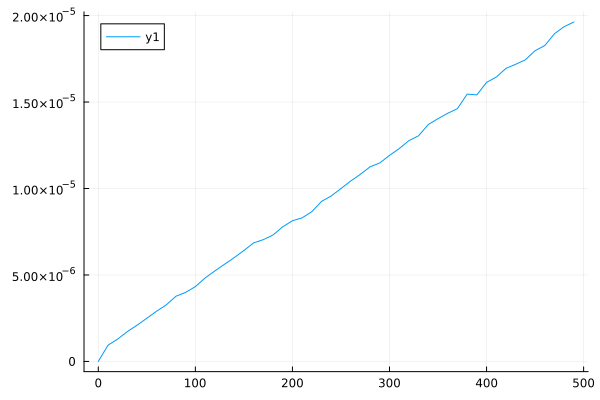

In [21]:
plot(tc[1:50].*au2fs, MSD, fmt= :png)

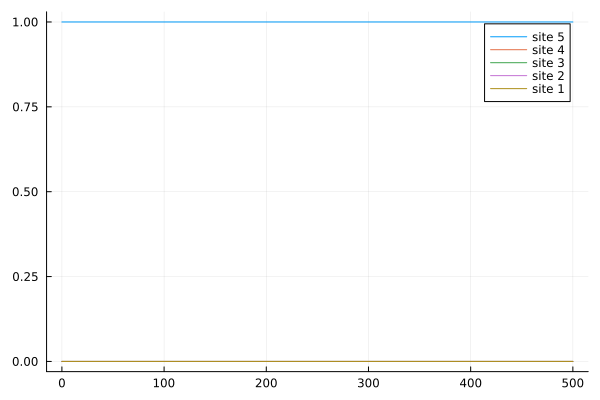

In [176]:
plot(tc.*au2fs, real.(ρc[:, 5, 5]), label="site 5")
plot!(tc.*au2fs, real.(ρc[:, 4, 4]), label="site 4")
plot!(tc.*au2fs, real.(ρc[:, 3, 3]), label="site 3")
plot!(tc.*au2fs, real.(ρc[:, 2, 2]), label="site 2")
plot!(tc.*au2fs, real.(ρc[:, 1, 1]), label="site 1")

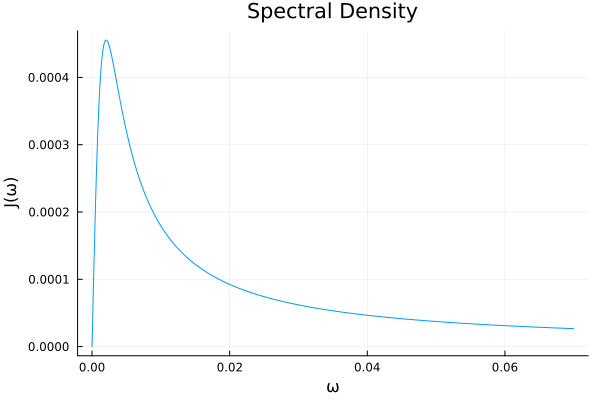

In [219]:
Jw2 = SpectralDensities.DrudeLorentz(λ=100*invcm2au, γ=450*invcm2au, Δs=1.0)
ω = 0:0.0001:0.07
ωs2, cs2 = SpectralDensities.discretize(Jw2, 100)
plot(ω, Jw2.(ω), xlabel="ω", ylabel="J(ω)", title="Spectral Density", legend=false)

QCPI simulation with most similar looking Drude-Lorentz Spectral Density

In [220]:
s1 = Vector{Float64}(zeros(N))
s2 = Matrix{Float64}(zeros(1, N))

for i in 1:N
    s1[i] = i
    s2[i] = i
end

In [221]:
s1

15-element Vector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
 14.0
 15.0

In [222]:
s2

1×15 Matrix{Float64}:
 1.0  2.0  3.0  4.0  5.0  6.0  7.0  …  10.0  11.0  12.0  13.0  14.0  15.0

In [ ]:
hb2 = Solvents.HarmonicBath(β, ωs2, cs2, s1.*d, 1000)
tc2, ρc2 = QCPI.propagate(; Hamiltonian=H0, Jw=Jw2, solvent=hb2, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=s2.*d, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

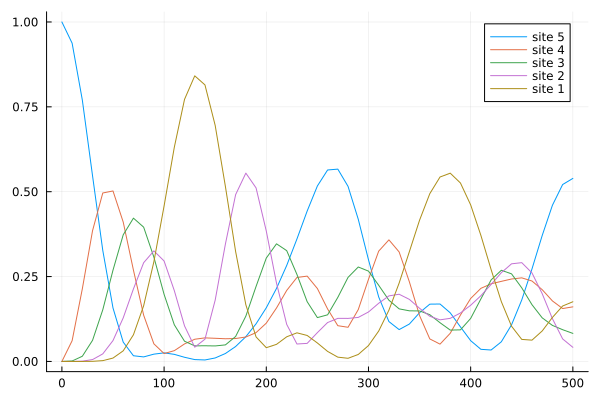

In [181]:
plot(tc2.*au2fs, real.(ρc2[:, 5, 5]), label="site 5")
plot!(tc2.*au2fs, real.(ρc2[:, 4, 4]), label="site 4")
plot!(tc2.*au2fs, real.(ρc2[:, 3, 3]), label="site 3")
plot!(tc2.*au2fs, real.(ρc2[:, 2, 2]), label="site 2")
plot!(tc2.*au2fs, real.(ρc2[:, 1, 1]), label="site 1")

In [184]:
MSD2 = []
for i in 1:50
    s = 0.0
    for j in 1:N
        s += real(ρc2[i, j, j])*(j-5)^2
    end
    push!(MSD2, s)
end
μ = β * (MSD2[50] - MSD2[1])/((tc2[50] - tc2[1])*au2fs)

8.031235970906234

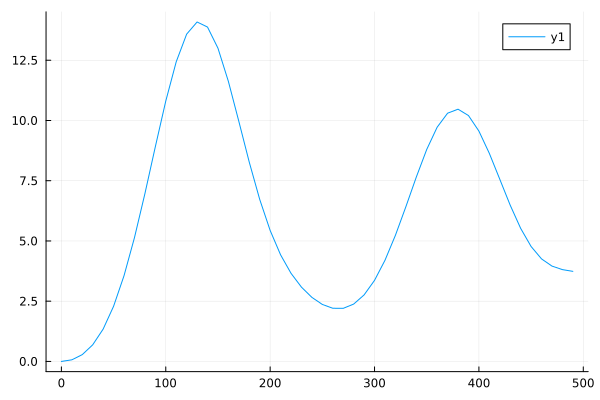

In [185]:
plot(tc2[1:50].*au2fs, MSD2, fmt= :png)

In [ ]:
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)